In [ ]:
!pip install pytorch_tabnet

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
path = './drive/MyDrive/Materiale_Pellegrino_personal/CTU_Shuffled/CTU_Shuffled.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DATI***

In [ ]:
dataset = dataset.drop('StartTime', axis=1)

In [ ]:
dataset

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,<->,CON,0.0,0.0,2,131,71,flow=Background-UDP-Established,normal
1,0.014909,2,->,SRPA_FSPA,0.0,0.0,11,2882,1504,flow=Background-TCP-Established,normal
2,0.000798,1,<->,CON,0.0,0.0,2,244,182,flow=Background-UDP-Established,normal
3,15.302759,1,->,INT,0.0,NaN,4,336,336,flow=Background-UDP-Attempt,normal
4,7.843942,2,->,FSPA_SRPA,0.0,0.0,93,11846,4562,flow=Background-TCP-Established,normal
...,...,...,...,...,...,...,...,...,...,...,...
31468,8.917003,2,->,S_SA,0.0,0.0,8,512,194,flow=Background-TCP-Established,normal
31469,0.038780,1,<->,CON,0.0,0.0,2,191,68,flow=To-Background-UDP-CVUT-DNS-Server,normal
31470,603.106201,1,->,INT,0.0,NaN,6,552,552,flow=Background-Attempt-cmpgw-CVUT,normal
31471,0.000550,1,<->,CON,0.0,0.0,2,128,60,flow=Background-UDP-Established,normal


In [ ]:
dep_var = 'multilabel'
cat_names = ["Dir", "State", "Details"]
cont_names = [col for col in dataset.columns if col != dep_var]

print(cont_names, 'len: ', len(cont_names))
print(cat_names, 'len: ', len(cat_names))

['Dur', 'Proto', 'Dir', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes', 'Details'] len:  10
['Dir', 'State', 'Details'] len:  3


In [ ]:
cat_names

['Dir', 'State', 'Details']

In [ ]:
# LabelEncoding della variabile target 
target_index = dataset.columns.get_loc(dep_var)
dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[dep_var])

#LabelEncoding delle variabili categoriali
for col in ["Dir", "State", "Details"]:
  target_index = dataset.columns.get_loc(col)
  dataset.iloc[:, target_index] = LabelEncoder().fit_transform(dataset[col])

# Fill NaN
""" Eliminiamo dalle colonne i valori nan """ 
for col in dataset.columns:
  dataset[col] = dataset[col].fillna(0)


In [ ]:
dataset

,Dur,Proto,Dir,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Details,multilabel
0,0.000540,1,3,4,0.0,0.0,2,131,71,6,1
1,0.014909,2,0,89,0.0,0.0,11,2882,1504,4,1
2,0.000798,1,3,4,0.0,0.0,2,244,182,6,1
3,15.302759,1,0,53,0.0,0.0,4,336,336,5,1
4,7.843942,2,0,43,0.0,0.0,93,11846,4562,4,1
...,...,...,...,...,...,...,...,...,...,...,...
31468,8.917003,2,0,99,0.0,0.0,8,512,194,4,1
31469,0.038780,1,3,4,0.0,0.0,2,191,68,46,1
31470,603.106201,1,0,53,0.0,0.0,6,552,552,1,1
31471,0.000550,1,3,4,0.0,0.0,2,128,60,6,1


In [ ]:
# Indice e dim delle variabili categoriali per l'incorporamento

features = [col for col in dataset.columns]

cat_idxs = [i for i, f in enumerate(features) if f in cat_names]

cat_dims = []
for col in cat_names:
  cat_dims.append(len(Counter(dataset[col])))

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
y_train = train[dep_var]
train = train.drop(dep_var, axis=1)
y_test = test[dep_var]
test = test.drop(dep_var, axis=1)

# validation di 2500 righe da train
train, validation, y_train, y_val = train_test_split(train, y_train, test_size=(2500/len(train)), random_state=0)

In [ ]:
train = np.array(train)
validation = np.array(validation)
test = np.array(test)

y_train = np.array(y_train)
y_val = np.array(y_val)

In [ ]:
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [ ]:
model = TabNetClassifier(n_d=64, n_a=64, n_steps=5,optimizer_fn=torch.optim.Adam, cat_idxs=cat_idxs, cat_dims=cat_dims,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
                      )

Device used : cuda


In [ ]:
# fit the model 
model.fit(
    train,y_train,
    eval_set=[(train, y_train), (validation, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=2056 , patience=50,
    batch_size=512, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)  

epoch 0  | loss: 0.39484 | train_accuracy: 0.87315 | valid_accuracy: 0.8708  |  0:00:02s
epoch 1  | loss: 0.09781 | train_accuracy: 0.9555  | valid_accuracy: 0.9596  |  0:00:05s
epoch 2  | loss: 0.03423 | train_accuracy: 0.39037 | valid_accuracy: 0.3972  |  0:00:07s
epoch 3  | loss: 0.02895 | train_accuracy: 0.98806 | valid_accuracy: 0.984   |  0:00:10s
epoch 4  | loss: 0.03352 | train_accuracy: 0.98965 | valid_accuracy: 0.9868  |  0:00:12s
epoch 5  | loss: 0.00911 | train_accuracy: 0.99924 | valid_accuracy: 0.9984  |  0:00:15s
epoch 6  | loss: 0.00433 | train_accuracy: 0.99932 | valid_accuracy: 0.9988  |  0:00:18s
epoch 7  | loss: 0.01964 | train_accuracy: 0.99773 | valid_accuracy: 0.9956  |  0:00:20s
epoch 8  | loss: 0.00782 | train_accuracy: 0.98436 | valid_accuracy: 0.9864  |  0:00:23s
epoch 9  | loss: 0.00478 | train_accuracy: 0.99902 | valid_accuracy: 0.9984  |  0:00:25s
epoch 10 | loss: 0.00275 | train_accuracy: 0.99992 | valid_accuracy: 0.9992  |  0:00:28s
epoch 11 | loss: 0.00

In [ ]:
y_pred = model.predict(test)

In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({1: 15703, 0: 34})
Pred: Counter({1: 15691, 0: 46})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

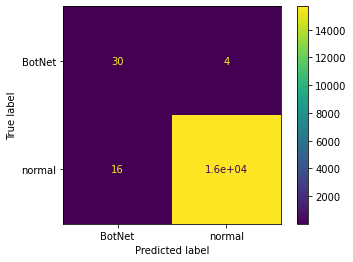

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_dict = {'BotNet' : 0,
               'normal' : 1}

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[15687    16]
  [    4    30]]

 [[   30     4]
  [   16 15687]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [   30 15687]
True negative:  [15687    30]
False positive:  [16  4]
False negative:  [ 4 16]
True positive rate:  [0.88235294 0.99898109]
True negative rate:  [0.99898109 0.88235294]
False positive rate:  [0.00101891 0.11764706]
False negative rate:  [0.11764706 0.00101891]


In [ ]:
print(cm)

[[   30     4]
 [   16 15687]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.65      0.88      0.75        34
           1       1.00      1.00      1.00     15703

    accuracy                           1.00     15737
   macro avg       0.83      0.94      0.87     15737
weighted avg       1.00      1.00      1.00     15737



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.9987291097413739
Precision_weighted:  0.998994144625089
Recall_weighted:  0.9987291097413739
mcc:  0.7579962987899742
f2:  0.9987821054672453


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred) # accuracy
mcc = matthews_corrcoef(y_test, y_pred)   # mcc
recall = recall_score(y_test, y_pred, average='weighted') # recall
precision = precision_score(y_test, y_pred, average='weighted') # precision
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))  # F2
mcm = multilabel_confusion_matrix(y_test, y_pred) # Multilabel confusione Matrix

# True/False Positive and True/False Negative
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
